In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Load Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
np.random.seed(10)
random_dim = 100

# Load MNIST

In [4]:
# Load the MNIST dataset and normalize each pixel value to 0-1 range.
def load_mnist():
  (x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
  x_train, x_test = (x_train-127.5)/127.5, (x_test-127.5)/127.5
  x_train = x_train.reshape((-1,28,28,1))
  x_test = x_test.reshape((-1,28,28,1))
  return (x_train, y_train, x_test, y_test)

# Generator

In [5]:
# Define a Generator
def define_generator(latent_dim):
  # takes 2 input: latent_vec and label
  # foundation of image
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(128*7*7, activation='relu', input_dim=latent_dim))
  model.add(tf.keras.layers.Reshape((7,7,128)))
  model.add(tf.keras.layers.UpSampling2D())
  model.add(tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'))
  model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  model.add(tf.keras.layers.UpSampling2D())
  model.add(tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'))
  model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  model.add(tf.keras.layers.Conv2D(1,3,padding='same',activation='tanh'))

  # label encoding
  z = tf.keras.layers.Input(shape=(latent_dim,))
  label = tf.keras.layers.Input(shape=(1,),dtype='uint8')
  label_embed = tf.keras.layers.Embedding(10, latent_dim, input_length=1)(label)
  label_embed = tf.keras.layers.Flatten()(label_embed)
  combined = tf.keras.layers.multiply([z, label_embed])

  img = model(combined)

  return tf.keras.models.Model([z, label], img)

latent_dim = 100
g_model = define_generator(latent_dim)
g_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 100)               1000      ['input_2[0][0]']             
                                                                                                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 flatten (Flatten)           (None, 100)                  0         ['embedding[0][0]']           
                                                                                              

# Discriminator

In [6]:
# create a discriminator network to differentiate between real and fake image
def define_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32,(3,3),2,input_shape=(28,28,2),padding='same'))
  model.add(tf.keras.layers.LeakyReLU(0.2))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Conv2D(64,(3,3),2,padding='same'))
  model.add(tf.keras.layers.LeakyReLU(0.2))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  img = tf.keras.layers.Input(shape=(28, 28, 1))
  label = tf.keras.layers.Input(shape=(1,))
  label_embed = tf.keras.layers.Embedding(input_dim=10, output_dim=np.prod((28,28)), input_length=1)(label)
  label_embed = tf.keras.layers.Flatten()(label_embed)
  label_embed = tf.keras.layers.Reshape((28, 28, 1))(label_embed)
  concatenated = tf.keras.layers.Concatenate(axis=-1)([label_embed, img])
  prediction = model(concatenated)
  return tf.keras.models.Model([img, label], prediction)

d_model = define_discriminator()
d_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 784)               7840      ['input_4[0][0]']             
                                                                                                  
 flatten_2 (Flatten)         (None, 784)                  0         ['embedding_1[0][0]']         
                                                                                                  
 reshape_1 (Reshape)         (None, 28, 28, 1)            0         ['flatten_2[0][0]']           
                                                                                            

In [7]:
d_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
z = tf.keras.layers.Input(shape=(100,))
label = tf.keras.layers.Input(shape=(1,))
img = g_model([z, label])

d_model.trainable = False
prediction = d_model([img, label])
cgan = tf.keras.models.Model([z, label], prediction)
cgan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cgan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 model (Functional)          (None, 28, 28, 1)            857193    ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 model_1 (Functional)        (None, 1)                    1633601   ['model[0][0]',         

# Split

In [9]:
x_train, y_train, x_test, y_test = load_mnist()

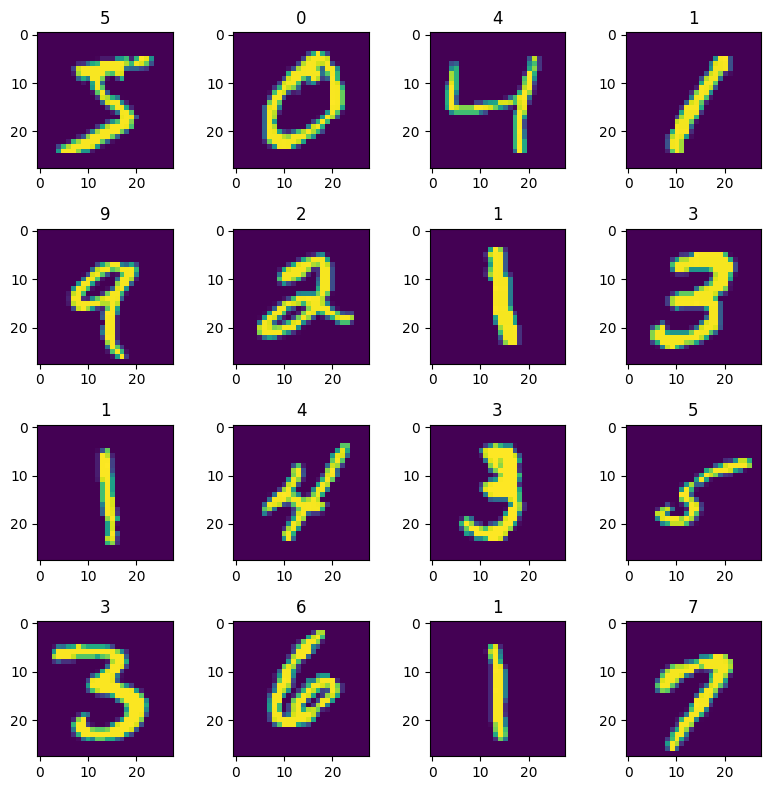

In [10]:
def plot_image(images, labels, rows, cols):
  w=10
  h=10
  fig=plt.figure(figsize=(8, 8))
  for i in range(1, cols*rows +1):
      img = images[i-1]
      ax = fig.add_subplot(rows, cols, i)
      ax.title.set_text(labels[i-1])
      plt.imshow(img.reshape((28,28)))
  fig.tight_layout()
  plt.show()

samples = x_train[:4*4]
labels = y_train[:4*4]
plot_image(samples,labels, 4,4)

# Train

(60000, 28, 28, 1)
Epochs>>>>>> 0
4/4 [==============================] - 24s 435ms/step
Losses(d,g): 0.7745563387870789 [0.2969997525215149, 1.0]
1/1 [==============================] - 1s 750ms/step


c:\Users\silwa\.conda\envs\daks\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


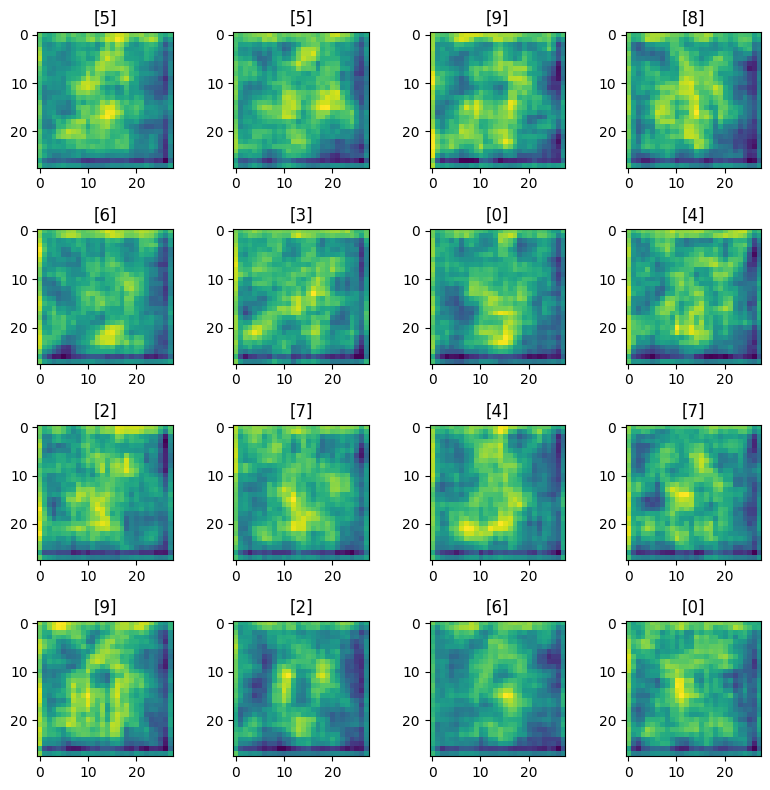

Epochs>>>>>> 1
4/4 [==============================] - 1s 160ms/step
Epochs>>>>>> 2
4/4 [==============================] - 1s 157ms/step
Epochs>>>>>> 3
4/4 [==============================] - 1s 158ms/step
Epochs>>>>>> 4
4/4 [==============================] - 1s 165ms/step
Epochs>>>>>> 5
4/4 [==============================] - 1s 227ms/step
Epochs>>>>>> 6
4/4 [==============================] - 1s 226ms/step
Epochs>>>>>> 7
4/4 [==============================] - 1s 162ms/step
Epochs>>>>>> 8
4/4 [==============================] - 1s 178ms/step
Epochs>>>>>> 9
4/4 [==============================] - 1s 222ms/step
Epochs>>>>>> 10
4/4 [==============================] - 1s 180ms/step
Epochs>>>>>> 11
4/4 [==============================] - 1s 225ms/step
Epochs>>>>>> 12
4/4 [==============================] - 1s 148ms/step
Epochs>>>>>> 13
4/4 [==============================] - 1s 154ms/step
Epochs>>>>>> 14
4/4 [==============================] - 1s 150ms/step
Epochs>>>>>> 15
4/4 [======================

In [ ]:
import os

epochs = 29000
batch_size = 128
save_interval = 1000

print(x_train.shape)

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

losses = {"G":[], "D":[]}

samples_test = np.random.normal(0,1,(16, 100))
labels_test = np.random.randint(0, 10, 16).reshape((-1, 1))

for epoch in range(epochs):
    print("Epochs>>>>>>",epoch)
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs, labels = x_train[idx], y_train[idx]

    noise = np.random.normal(0,1,(batch_size, 100))
    fake_imgs = g_model.predict([noise, labels])

    # train discriminator
    d_model.trainable = True
    d_loss_real = d_model.train_on_batch([real_imgs, labels], valid)
    d_loss_fake = d_model.train_on_batch([fake_imgs, labels], fake)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    d_model.trainable = False

    z = np.random.normal(0,1, size=(batch_size, 100))
    labels = np.random.randint(0, 10, batch_size).reshape((-1, 1))

    # train generator
    g_loss = cgan.train_on_batch([z, labels], valid)

    losses["G"].append(g_loss)
    losses["D"].append(d_loss)

    if epoch % save_interval == 0:
        print("Losses(d,g):", d_loss[0], g_loss)
        results = g_model.predict([samples_test, labels_test])
        plot_image(results, labels_test, 4, 4)

In [12]:
d_model.save('/content/drive/MyDrive/discriminator.h5')
g_model.save('/content/drive/MyDrive/generator.h5')
cgan.save('/content/drive/MyDrive/cgan.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
